<a href="https://colab.research.google.com/github/camiloodiaboalves/ResTIC_CNN_Grupo2_Proj10/blob/main/Unidade_10_Restic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importações

## Dataset

In [ ]:
!pip install kaggle
!pip install keras-tuner -q
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs --force
!unzip -oq "cuhk-face-sketch-database-cufs.zip"
!pip install pillow

Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
 88% 99.0M/113M [00:00<00:00, 343MB/s]
100% 113M/113M [00:00<00:00, 277MB/s] 


## Bibliotecas

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image as PILImage
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score,roc_curve,roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import display, Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from IPython.display import display
import pandas as pd
from torchvision import transforms
from tensorflow.keras import backend as K
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

# Funções

In [ ]:


def list_files_in_folder(folder_path): #Retorna o nome dos arquivos na pasta.
  try:
    file_list = os.listdir(folder_path)
    return file_list
  except FileNotFoundError:
    print(f"Error: Folder not found at {folder_path}")
    return []
def display_images_from_folder(folder_path): #Mostra todas as imagens da pasta
  image_files = list_files_in_folder(folder_path)
  if not image_files:
    print(f"No images found in folder: {folder_path}")
    return

  for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    print(f"Exibindo: {image_file}")
    display(Image(filename=image_path))

def label_sex(folder_path): #Retorna uma lista de rótulos 0 ou 1 baseado
                            #no nome do arquivo. Intero que chequei todos os
                            #arquivo para verificar se seguem esse padrão.
  labels=[]
  image_files = list_files_in_folder(folder_path)
  for file in image_files:
    if file.startswith('m'):
      labels.append(0)
    else:
      labels.append(1)
  return labels;

def norm_image (folder_path): #Retorna uma lista de tensors normalizados.
                              #Não fiz nenhum reshape nas imagens. Chequei e
                              #percebi que todas estavam no padrão 250x200
                              #pixelsm
  normalized_images = []
  image_files = list_files_in_folder(folder_path)
  for file in image_files:
    image_path = os.path.join(folder_path, file)
    image = PILImage.open(image_path)
    image_array = np.array(image) / 255.0
    normalized_images.append(image_array)
  return normalized_images

def graying_image(folder_path): #Essa função cria uma pasta e armazena as
                                #imagens em preto e branco.
  input_folder = folder_path
  output_folder = "photos_gray"
  os.makedirs(output_folder, exist_ok=True)

  for file in list_files_in_folder(folder_path):
    image_path = os.path.join(input_folder, file)
    # Abrir a imagem
    with PILImage.open(image_path) as image:
        # Converter para escala de cinza
      gray_image = image.convert("L")
        # Salvar a imagem
      gray_image.save(os.path.join(output_folder, file))

def best_hp(hp,color_scale=3,nome="TESTE"):
  #Essa função é a usada para procurar os melhores parâmetros
  #Não utilizei ela nas fotos preto e branco

    model = models.Sequential(name=nome)
    hp_filters = hp.Choice('filters', values=[31, 62, 129])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4,1e-5])
    hp_activation = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'softmax'])

    #O compilador recomendou ter uma camada de input
    model.add(layers.Input(shape=(250, 200, color_scale)))

    model.add(layers.Conv2D(hp_filters, (6, 6), activation=hp_activation, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp_filters * 2, (5, 5), activation=hp_activation, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp_filters * 3, (4, 4), activation=hp_activation, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp_filters * 4, (3, 3), activation=hp_activation, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))



    model.add( tf.keras.layers.Flatten() )
    model.add( tf.keras.layers.Dense(1, activation='sigmoid') )
    model.compile(optimizer='adam',
              loss=['binary_crossentropy'],
              metrics=(['accuracy']))
    return model

def top_melhores_cnn_da_residencia(color_scale,nome,hp_activation,hp_filters,lr):
#Essa função gera meu modelo de arquitetura original com os parametros da
#retornados no grid search
    model = models.Sequential(name=nome)

    #O compilador recomendou ter uma camada de input
    model.add(layers.Input(shape=(250, 200, color_scale)))

    model.add(layers.Conv2D(hp_filters, (6, 6), activation=hp_activation, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp_filters * 2, (5, 5), activation=hp_activation, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp_filters * 3, (4, 4), activation=hp_activation, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp_filters * 4, (3, 3), activation=hp_activation, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))



    model.add( tf.keras.layers.Flatten() )
    model.add( tf.keras.layers.Dense(1, activation='sigmoid') )
    optimizer_custom = Adam(learning_rate=lr)
    model.compile(optimizer_custom,
              loss=['binary_crossentropy'],
              metrics=(['accuracy']))
    return model

# Treinos

##Modelo com imagens originais do dataset

In [ ]:
photos_folder = "photos"
files_in_photos = list_files_in_folder(photos_folder)

In [ ]:
#display_images_from_folder(photos_folder)

In [ ]:
labels = label_sex(photos_folder)


In [ ]:
normalized_images = norm_image(photos_folder)

In [ ]:
X = normalized_images  #Array de imagens normalizadas.
y = labels  #Rótulos.
#Eu estava um erro com o tamanho da entrada para o modelo. Aparentemente as
#dimensões estavam erradas no tensor. Essa função abaixo foi para ajeitar isso.
X= np.expand_dims(X, axis=-1)

#Dividindo em treino + temporário (50% treino, 50% temporário).
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=23)#colocar stratify no relatorio
#Dividindo o conjunto temporário em validação + teste (60% validação, 40% teste).
#No final ficamos com 50% treino, 20% teste e 30% validação.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=23)






X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
tuner = kt.Hyperband(#Treinando o modelo com gridsearch
    best_hp,
    objective=kt.Objective("accuracy", direction="max"),  # Maximizar o F1-score
    max_epochs=20,
    factor=3,
    directory='model_results_2',
    project_name='grid_search'
)

In [ ]:
#Pode demorar cerca de 15 min
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Trial 30 Complete [00h 00m 24s]
accuracy: 0.7553191781044006

Best accuracy So Far: 0.936170220375061
Total elapsed time: 00h 13m 00s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Melhores hiperparâmetros encontrados: {best_hps.values}")

Melhores hiperparâmetros encontrados: {'filters': 62, 'learning_rate': 0.01, 'activation': 'relu', 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


In [ ]:
activation = 'relu'
filters = 62
lr = 0.01
model = top_melhores_cnn_da_residencia(3,'M-1678',activation,filters,lr)

In [ ]:
model.summary()

Model: "M-1678"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 250, 200, 62)        │           6,758 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 125, 100, 62)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 125, 100, 124)       │         192,324 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 50, 124)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 62, 50, 186)         │         369,210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 25, 186)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 31, 25, 248)         │         415,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 12, 248)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 44640)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          44,641 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,028,333 (3.92 MB)

 Trainable params: 1,028,333 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)
model.fit(X_train,
          y_train,
          batch_size=16,
          epochs=20,
          verbose=1,
          callbacks=[early_stopping],)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 539ms/step - accuracy: 0.4926 - loss: 215.0421
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6679 - loss: 0.6876
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6830 - loss: 0.7398
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6946 - loss: 0.6255
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7176 - loss: 0.6088
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7050 - loss: 0.6102
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6419 - loss: 0.6636
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.6917 - loss: 0.6271
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7230 - loss: 0.5917
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7330 - loss: 0.5794
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.7618 - loss: 0.5944
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7525 - loss: 0.619

In [ ]:
model.save('face_model.keras')

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Loss na validação: {val_loss}")
print(f"Acurácia na validação: {val_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.7262 - loss: 0.5933
Loss na validação: 0.6013776063919067
Acurácia na validação: 0.7142857313156128


In [ ]:
pred = model.predict(X_val)
pred_labels = (pred > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


AUC-ROC: 0.5
F1-Score: 0.0


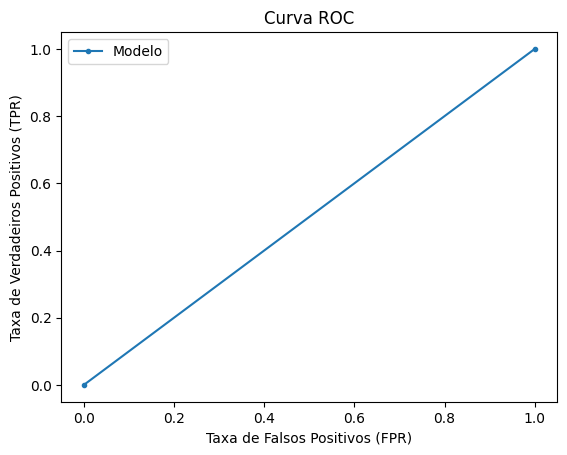

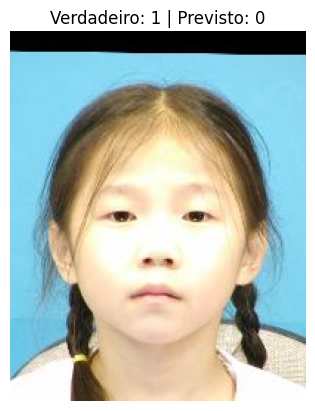

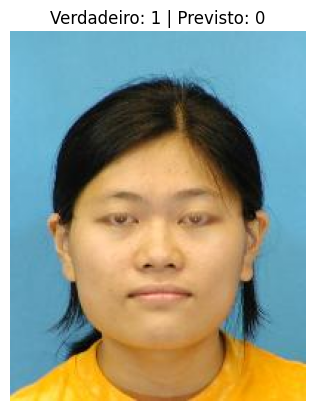

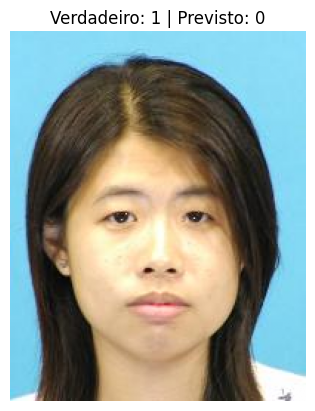

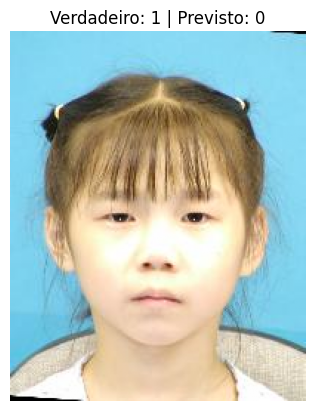

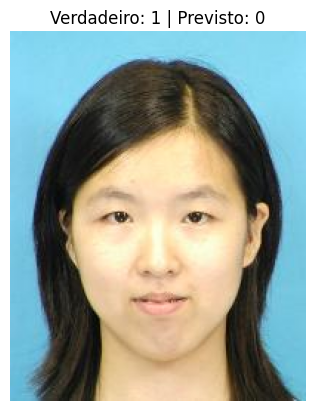

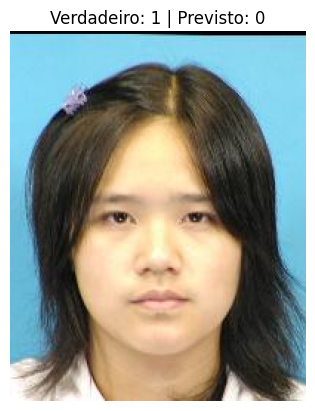

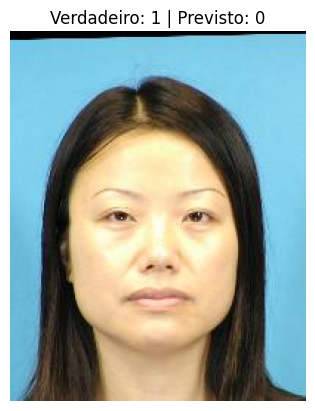

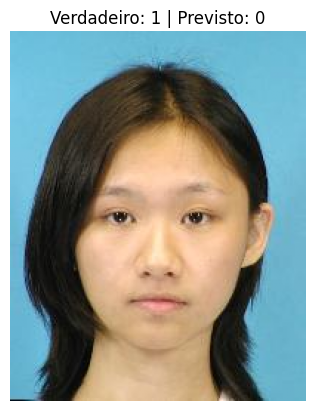

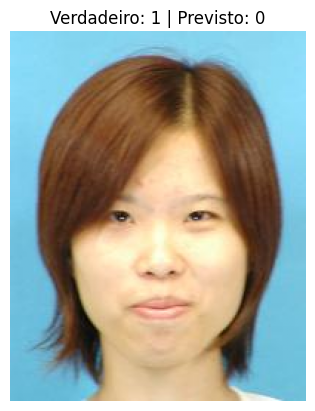

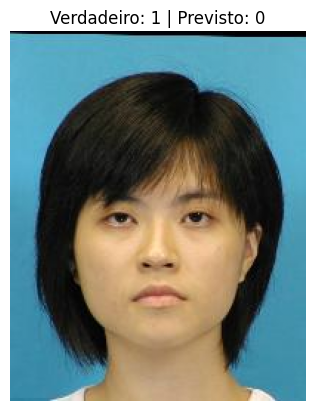

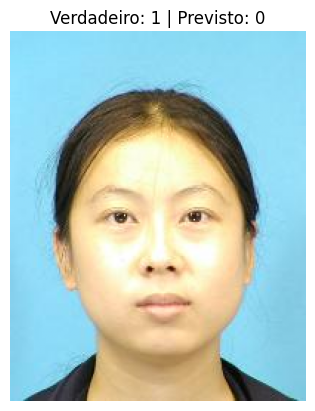

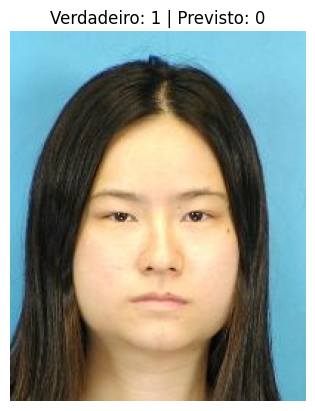

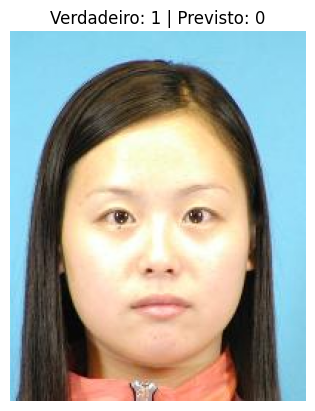

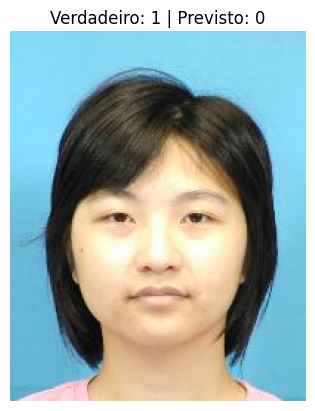

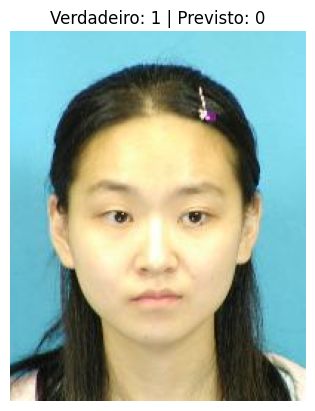

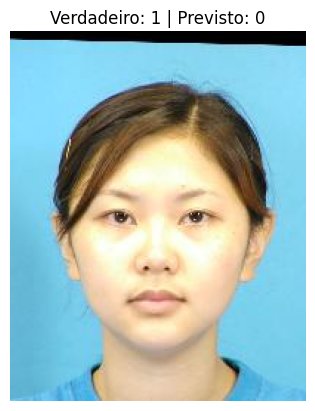

In [ ]:
auc = roc_auc_score(y_val, pred_labels)
print(f"AUC-ROC: {auc}")
f1 = f1_score(y_val, pred_labels)
print(f"F1-Score: {f1}")
fpr, tpr, thresholds = roc_curve(y_val, pred_labels)

# Plotando a curva ROC
plt.plot(fpr, tpr, marker='.', label='Modelo')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

for i in range(len(X_val)):
  if(y_val[i] !=pred_labels[i][0]):#Analisando as fotos em que o modelo errou a
                                   #previsão
      plt.imshow(X_val[i].reshape(250, 200,3), cmap=None)
      plt.title(f"Verdadeiro: {y_val[i]} | Previsto: {pred_labels[i][0]}")
      plt.axis('off')
      plt.show()

##Modelo com imagens convertidas para preto e branco

Como o objetivo é criar uma rede capaz de diferenciar rostos masculinos de femininos, transformei todas as imagens para preto e branco, já que a cor não é um fator importante na definição dessa característica. Porém, também farei o treinamento do modelo com as imagens originais para verificar se houve alguma melhora.

In [ ]:
graying_image(photos_folder)
photos_gray_folder = "photos_gray"

Exibindo: m1-018-01.jpg


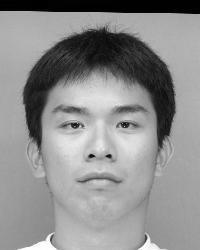

Exibindo: m-050-01.jpg


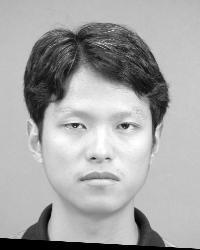

Exibindo: f-035-01.jpg


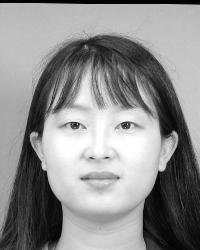

Exibindo: m-036-01.jpg


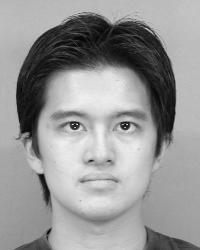

Exibindo: m-090-01.jpg


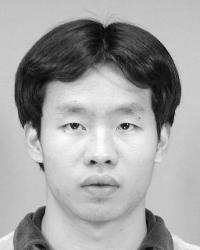

Exibindo: m-053-01.jpg


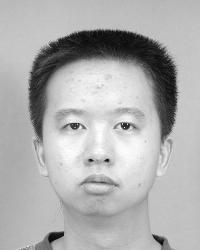

Exibindo: f-037-01.jpg


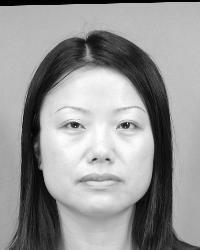

Exibindo: m1-008-01.jpg


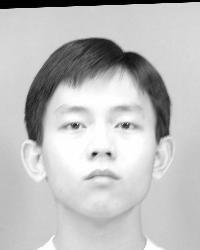

Exibindo: m-026-01.jpg


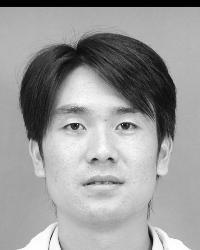

Exibindo: f1-005-01.jpg


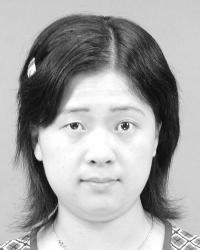

Exibindo: f1-006-01.jpg


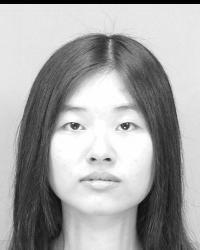

Exibindo: m-092-01.jpg


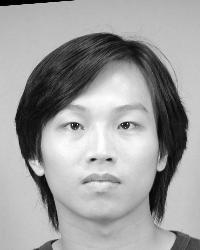

Exibindo: f1-001-01.jpg


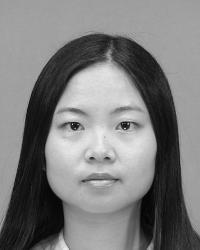

Exibindo: f1-004-01.jpg


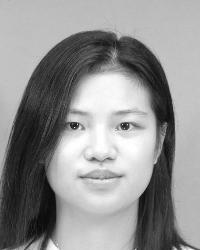

Exibindo: m-060-01.jpg


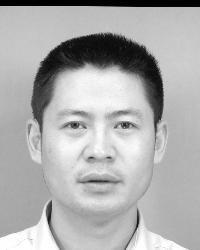

Exibindo: m1-040-01.jpg


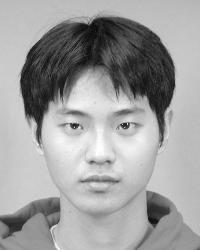

Exibindo: m-038-01.jpg


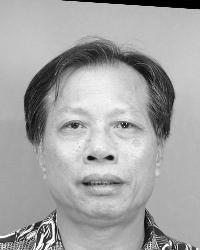

Exibindo: f-009-01.jpg


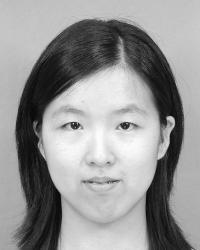

Exibindo: m1-025-01.jpg


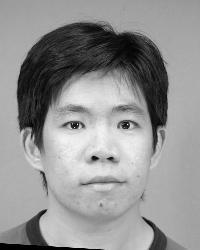

Exibindo: m1-038-01.jpg


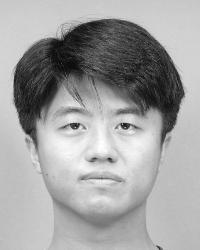

Exibindo: m-041-01.jpg


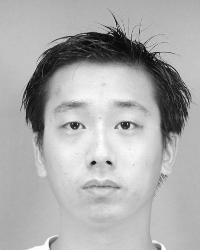

Exibindo: f1-007-01.jpg


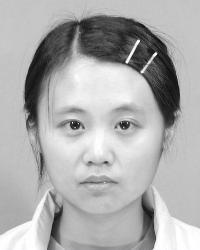

Exibindo: m1-011-01.jpg


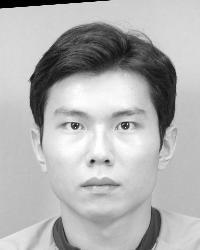

Exibindo: m1-015-01.jpg


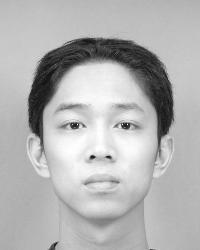

Exibindo: m1-006-01.jpg


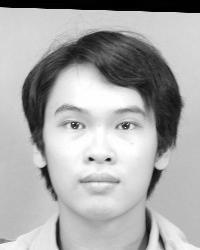

Exibindo: f-016-01.jpg


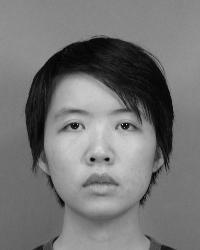

Exibindo: m-017-01.jpg


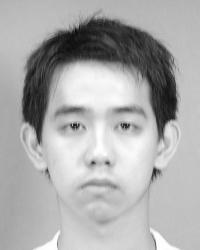

Exibindo: m-056-01.jpg


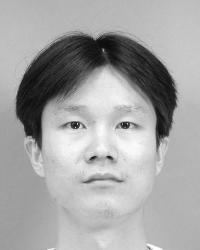

Exibindo: m-065-01.jpg


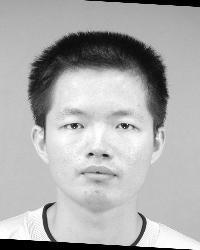

Exibindo: f-023-01.jpg


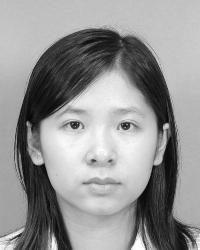

Exibindo: m-028-01.jpg


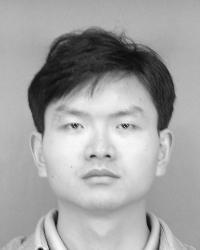

Exibindo: f-033-01.jpg


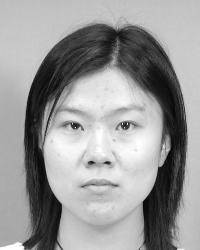

Exibindo: m1-027-01.jpg


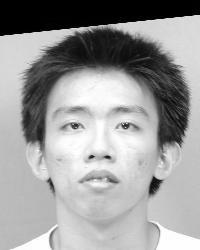

Exibindo: m1-012-01.jpg


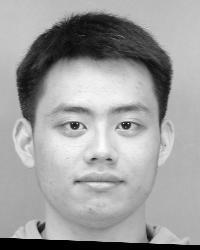

Exibindo: m1-020-01.jpg


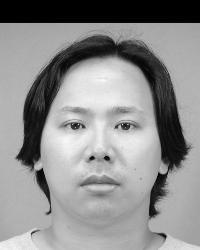

Exibindo: f-024-01.jpg


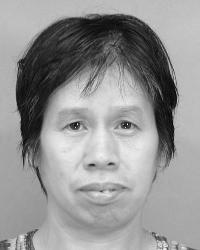

Exibindo: f-022-01.jpg


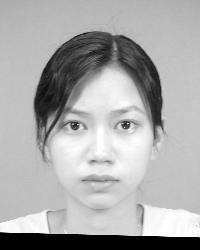

Exibindo: m1-005-01.jpg


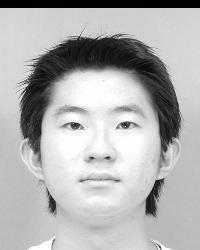

Exibindo: m-061-01.jpg


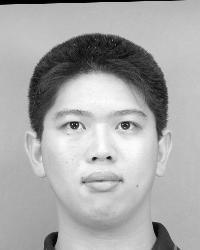

Exibindo: m1-003-01.jpg


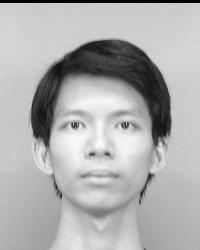

Exibindo: m-096-01.jpg


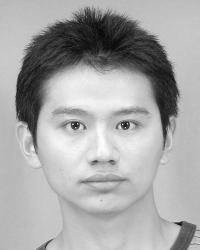

Exibindo: m1-017-01.jpg


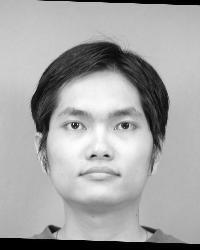

Exibindo: f-029-01.jpg


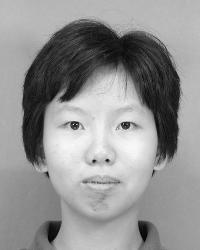

Exibindo: m-032-01.jpg


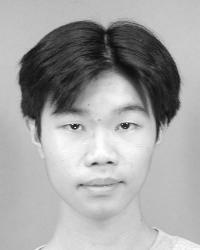

Exibindo: m-016-01.jpg


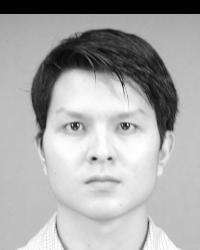

Exibindo: m-076-01.jpg


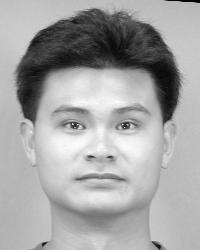

Exibindo: f1-012-01.jpg


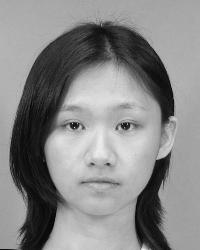

Exibindo: m-015-01.jpg


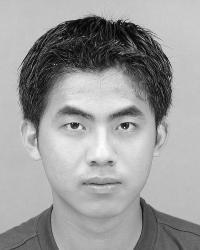

Exibindo: m1-016-01.jpg


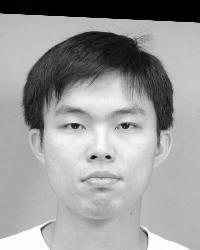

Exibindo: m-101-01.jpg


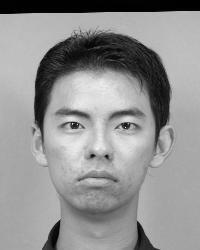

Exibindo: f-007-01.jpg


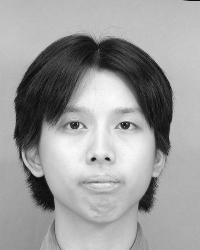

Exibindo: m1-014-01.jpg


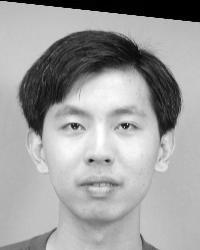

Exibindo: m-039-01.jpg


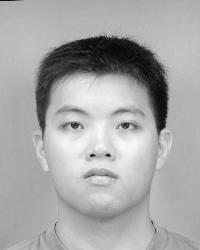

Exibindo: f-025-01.jpg


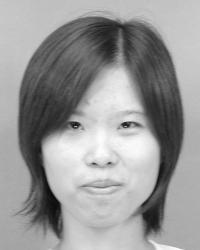

Exibindo: m-068-01.jpg


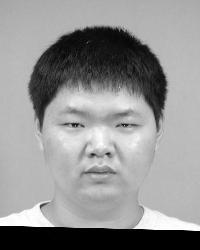

Exibindo: f-031-01.jpg


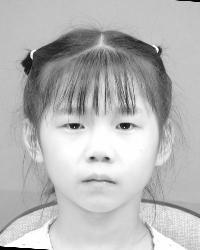

Exibindo: m-055-01.jpg


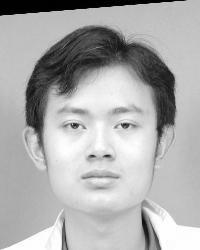

Exibindo: m-089-01.jpg


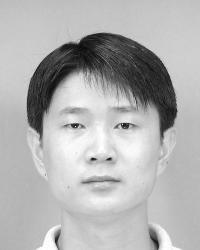

Exibindo: m-099-01.jpg


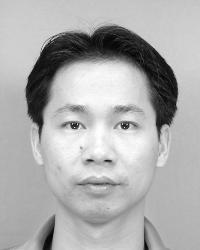

Exibindo: m-045-01.jpg


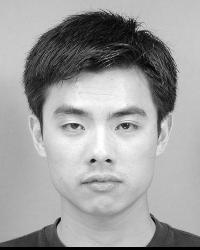

Exibindo: m1-035-01.jpg


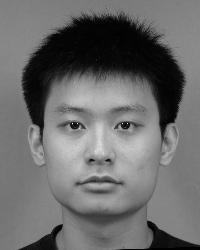

Exibindo: m-058-01.jpg


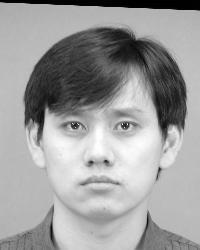

Exibindo: f-036-01.jpg


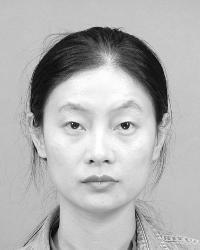

Exibindo: m-035-01.jpg


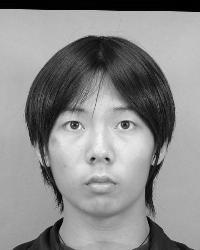

Exibindo: f1-011-01.jpg


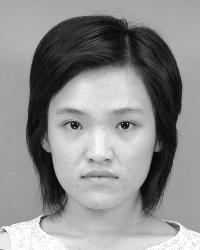

Exibindo: f-039-01.jpg


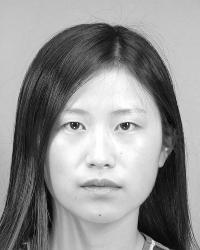

Exibindo: f-018-01.jpg


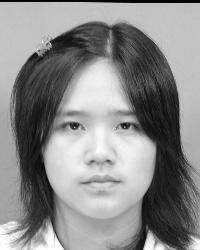

Exibindo: f-011-01.jpg


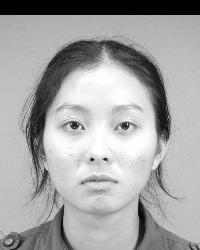

Exibindo: m-029-01.jpg


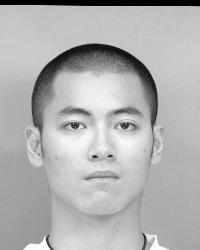

Exibindo: m-021-01.jpg


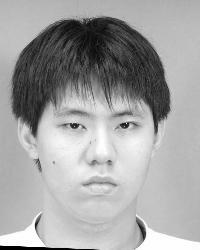

Exibindo: f-026-01.jpg


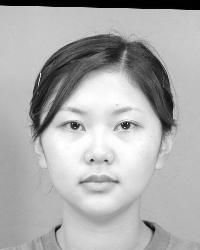

Exibindo: m-042-01.jpg


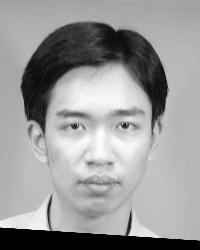

Exibindo: m-046-01.jpg


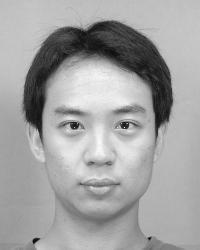

Exibindo: f-010-01.jpg


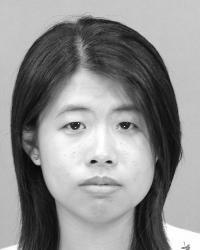

Exibindo: f-028-01.jpg


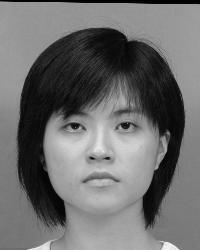

Exibindo: m-030-01.jpg


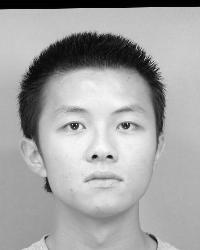

Exibindo: f1-010-01.jpg


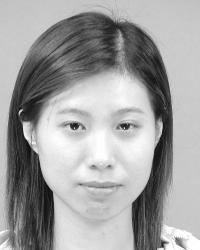

Exibindo: m1-019-01.jpg


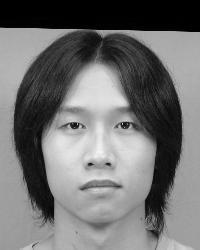

Exibindo: m1-004-01.jpg


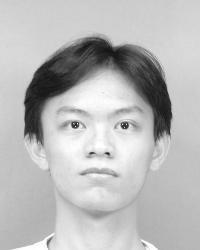

Exibindo: m-064-01.jpg


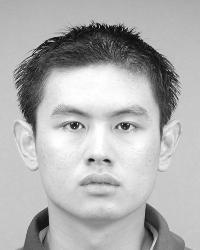

Exibindo: m-062-01.jpg


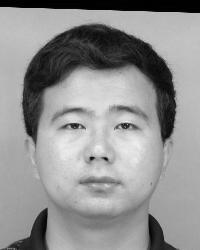

Exibindo: f-043-01.jpg


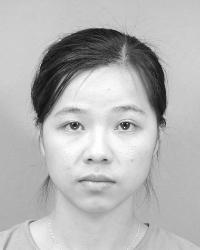

Exibindo: f-034-01.jpg


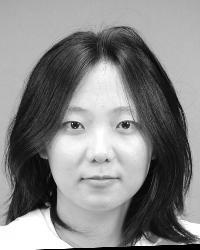

Exibindo: m-008-01.jpg


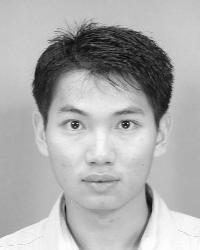

Exibindo: m-025-01.jpg


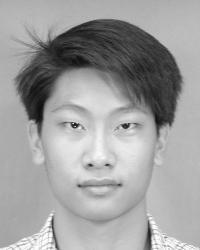

Exibindo: m-044-01.jpg


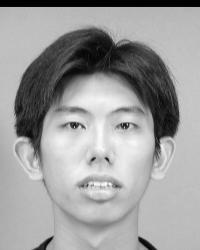

Exibindo: m-051-01.jpg


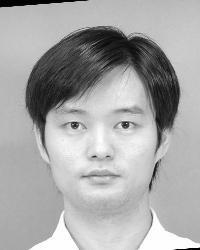

Exibindo: f1-008-01.jpg


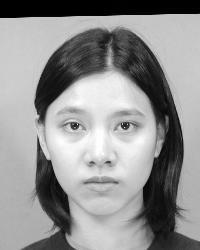

Exibindo: m-093-01.jpg


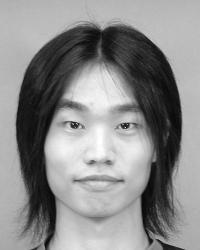

Exibindo: m1-009-01.jpg


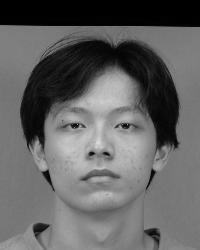

Exibindo: m1-024-01.jpg


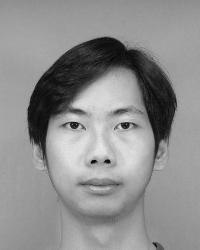

Exibindo: m-054-01.jpg


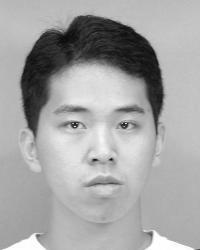

Exibindo: f-005-01.jpg


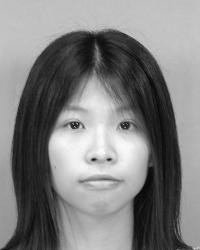

Exibindo: m-040-01.jpg


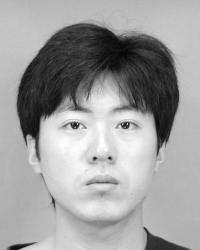

Exibindo: m-100-01.jpg


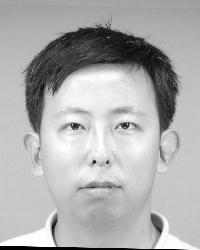

Exibindo: f-040-01.jpg


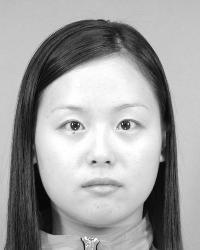

Exibindo: m1-034-01.jpg


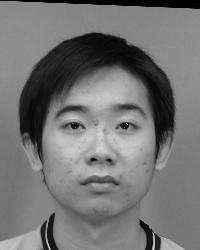

Exibindo: m-014-01.jpg


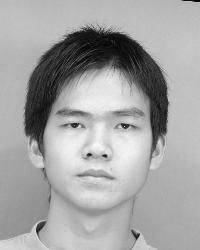

Exibindo: m1-002-01.jpg


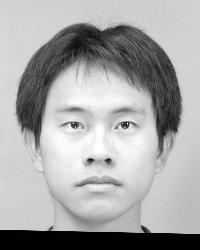

Exibindo: f1-003-01.jpg


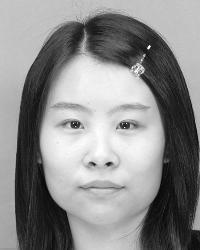

Exibindo: m1-032-01.jpg


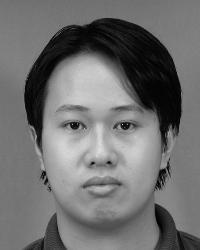

Exibindo: f-017-01.jpg


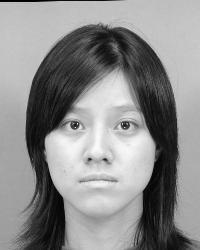

Exibindo: m1-039-01.jpg


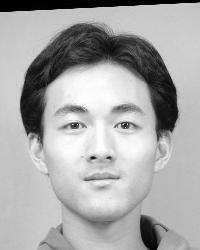

Exibindo: m-074-01.jpg


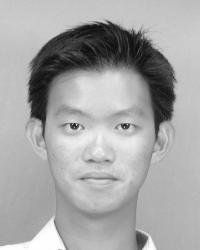

Exibindo: f-019-01.jpg


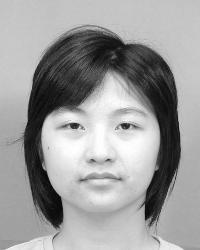

Exibindo: m-031-01.jpg


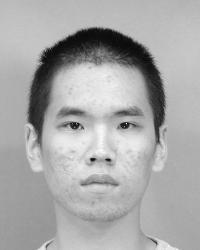

Exibindo: f-021-01.jpg


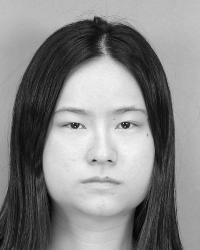

Exibindo: m1-022-01.jpg


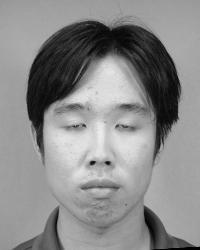

Exibindo: m-085-01.jpg


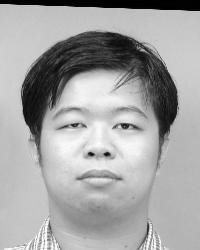

Exibindo: f-038-01.jpg


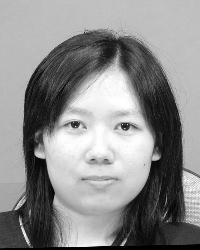

Exibindo: m-080-01.jpg


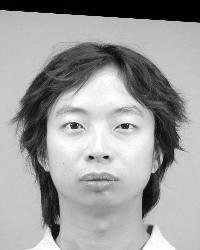

Exibindo: m-075-01.jpg


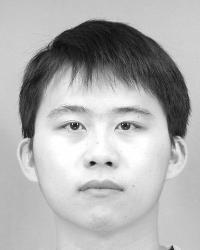

Exibindo: m1-023-01.jpg


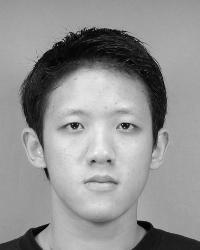

Exibindo: m-037-01.jpg


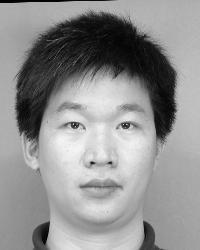

Exibindo: m1-029-01.jpg


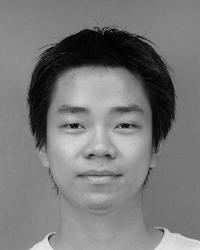

Exibindo: m-048-01.jpg


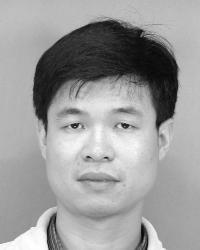

Exibindo: m-069-01.jpg


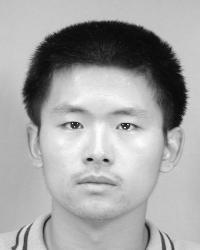

Exibindo: m-059-01.jpg


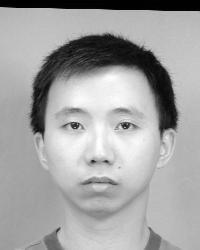

Exibindo: m-009-01.jpg


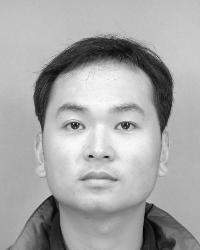

Exibindo: m-070-01.jpg


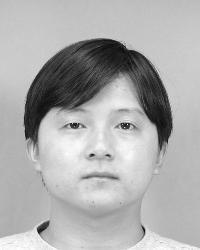

Exibindo: m-034-01.jpg


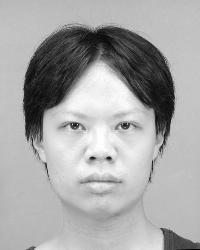

Exibindo: f-013-01.jpg


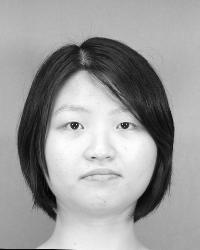

Exibindo: f-006-01.jpg


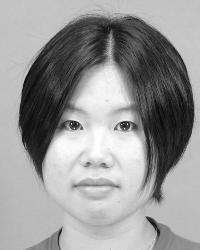

Exibindo: m-063-01.jpg


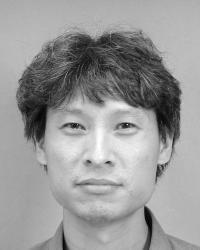

Exibindo: f-032-01.jpg


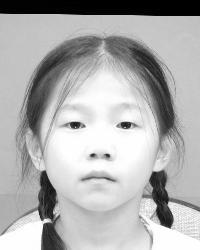

Exibindo: m-071-01.jpg


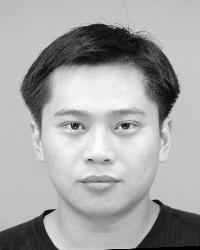

Exibindo: m-079-01.jpg


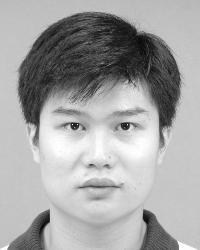

Exibindo: m-081-01.jpg


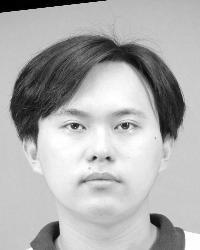

Exibindo: f-008-01.jpg


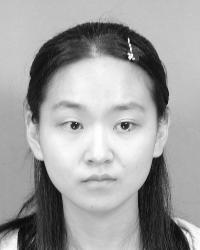

Exibindo: m1-030-01.jpg


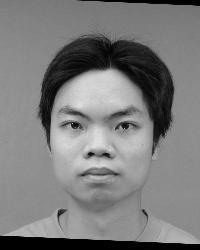

Exibindo: f1-014-01.jpg


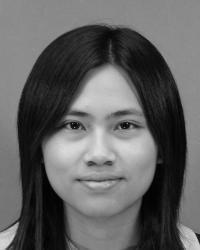

Exibindo: f-014-01.jpg


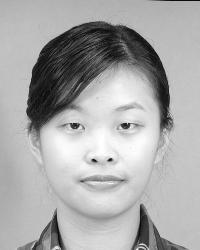

Exibindo: f1-002-01.jpg


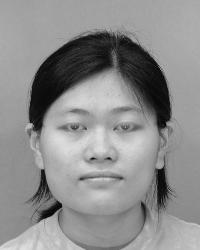

Exibindo: m-049-01.jpg


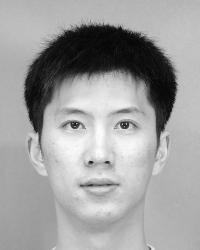

Exibindo: m-082-01.jpg


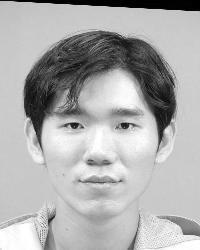

Exibindo: m1-001-01.jpg


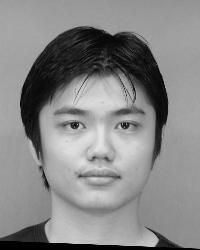

Exibindo: m1-031-01.jpg


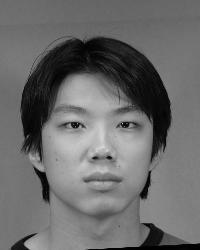

Exibindo: m-088-01.jpg


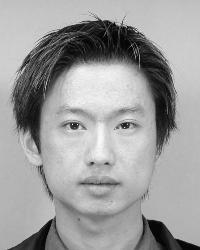

Exibindo: m-094-01.jpg


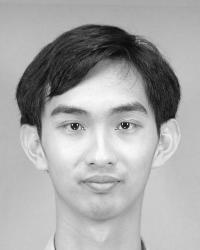

Exibindo: m-047-01.jpg


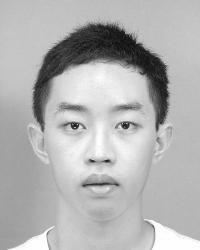

Exibindo: m-018-01.jpg


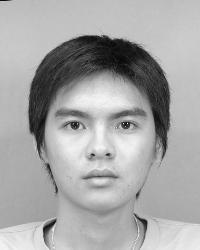

Exibindo: m-043-01.jpg


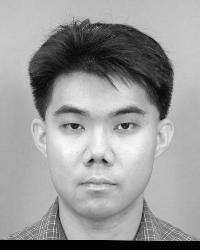

Exibindo: m-024-01.jpg


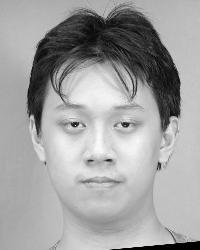

Exibindo: m1-037-01.jpg


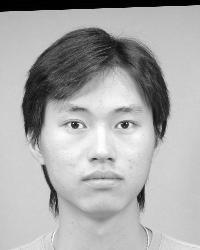

Exibindo: m-078-01.jpg


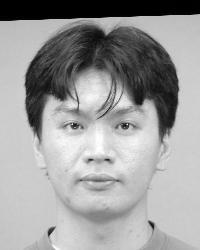

Exibindo: m1-033-01.jpg


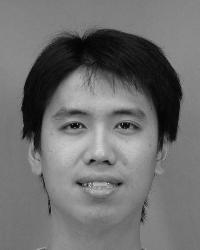

Exibindo: m-095-01.jpg


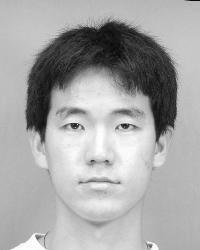

Exibindo: m1-036-01.jpg


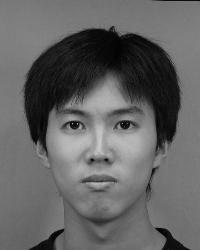

Exibindo: m-033-01.jpg


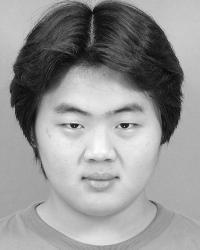

Exibindo: m-010-01.jpg


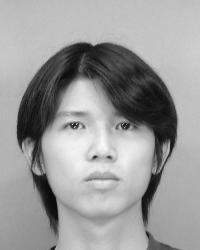

Exibindo: m1-007-01.jpg


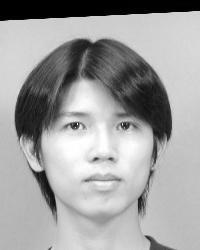

Exibindo: f-027-01.jpg


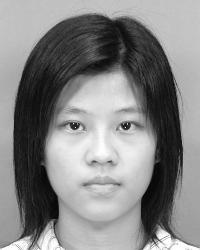

Exibindo: m1-028-01.jpg


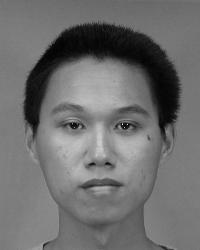

Exibindo: f-042-01.jpg


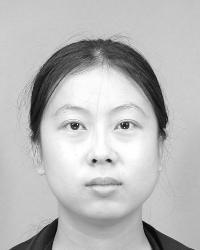

Exibindo: m-098-01.jpg


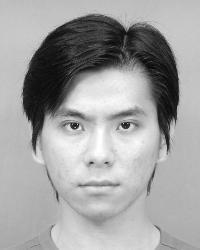

Exibindo: f1-015-01.jpg


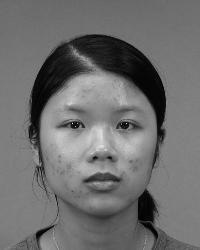

Exibindo: m-097-01.jpg


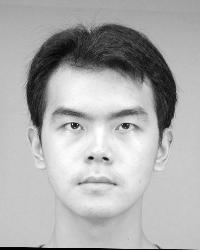

Exibindo: m-019-01.jpg


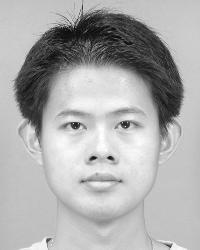

Exibindo: m-067-01.jpg


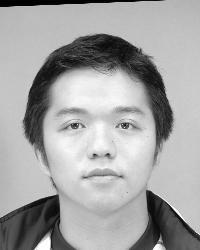

Exibindo: f-020-01.jpg


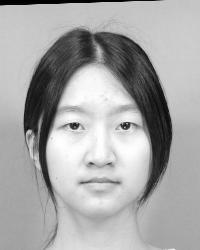

Exibindo: m-023-01.jpg


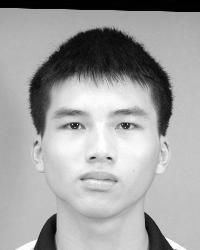

Exibindo: m-083-01.jpg


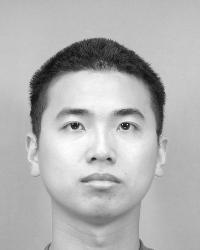

Exibindo: f-041-01.jpg


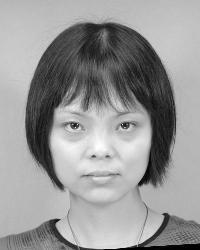

Exibindo: f1-013-01.jpg


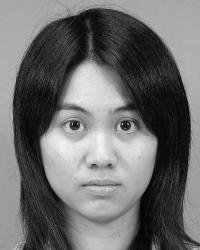

Exibindo: m-087-01.jpg


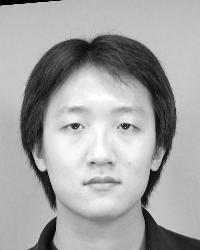

Exibindo: m1-021-01.jpg


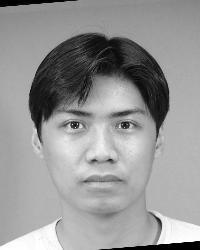

Exibindo: m-084-01.jpg


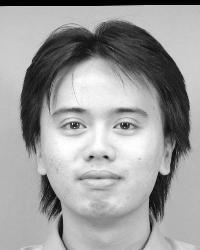

Exibindo: m-086-01.jpg


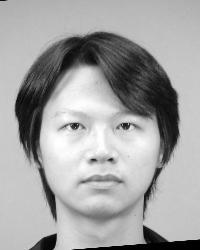

Exibindo: m-013-01.jpg


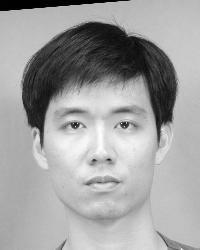

Exibindo: m-091-01.jpg


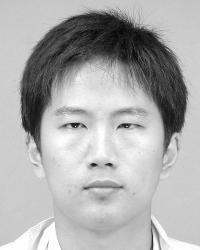

Exibindo: f-012-01.jpg


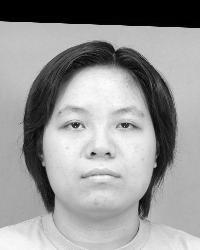

Exibindo: m-027-01.jpg


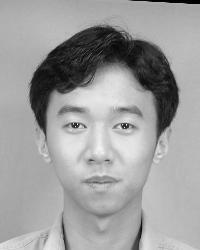

Exibindo: f1-009-01.jpg


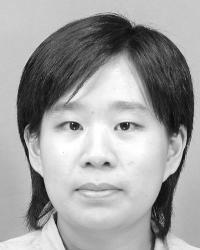

Exibindo: m-077-01.jpg


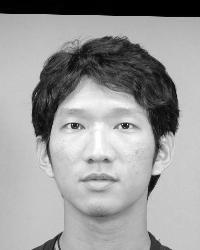

Exibindo: m-011-01.jpg


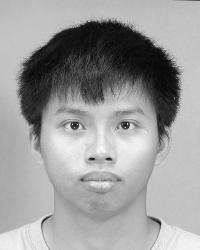

Exibindo: f-015-01.jpg


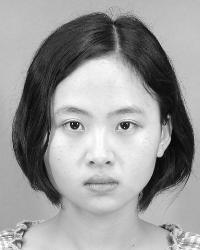

Exibindo: m-072-01.jpg


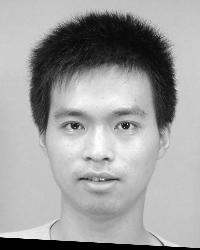

Exibindo: m-052-01.jpg


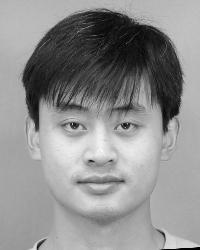

Exibindo: m-066-01.jpg


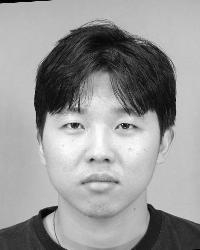

Exibindo: m1-010-01.jpg


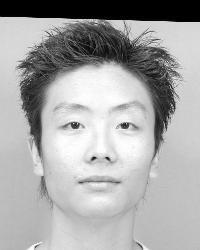

Exibindo: m-022-01.jpg


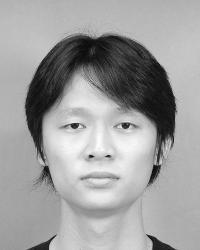

Exibindo: m1-013-01.jpg


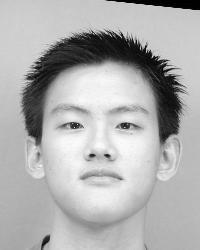

Exibindo: m1-026-01.jpg


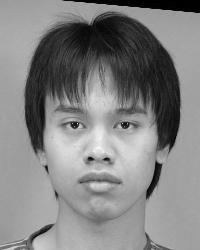

Exibindo: m-012-01.jpg


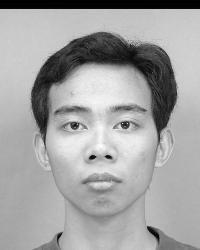

Exibindo: m-073-01.jpg


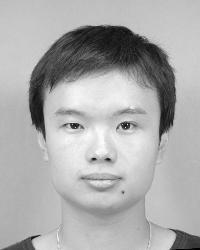

Exibindo: m-057-01.jpg


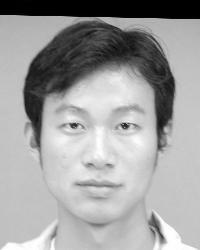

Exibindo: f-030-01.jpg


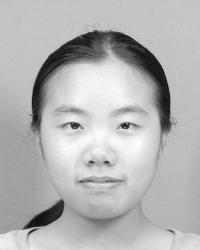

Exibindo: m1-041-01.jpg


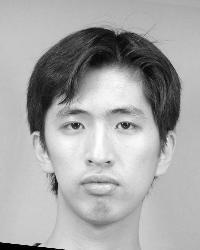

In [ ]:
display_images_from_folder(photos_gray_folder)

In [ ]:
labels = label_sex(photos_gray_folder)

In [ ]:
print(f"Quantidade de 0s: {labels.count(0)}")
print(f"Quantidade de 1s: {labels.count(1)}")

Quantidade de 0s: 134
Quantidade de 1s: 54


In [ ]:
normalized_gray_images = norm_image(photos_gray_folder)

In [ ]:
X = normalized_gray_images  #Array de imagens normalizadas.
y = labels  #Rótulos.
#Eu estava um erro com o tamanho da entrada para o modelo. Aparentemente as
#dimensões estavam erradas no tensor. Essa função abaixo foi para ajeitar isso.

#Dividindo em treino + temporário (50% treino, 50% temporário).
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=23)#colocar stratify no relatorio
#Dividindo o conjunto temporário em validação + teste (60% validação, 40% teste).
#No final ficamos com 50% treino, 20% teste e 30% validação.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=23)






X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
model_gray = top_melhores_cnn_da_residencia(1,'G-0909',activation,filters,lr)
model_gray.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "M-1678"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 250, 200, 62)        │           6,758 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 125, 100, 62)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 100, 124)       │         192,324 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 62, 50, 124)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 62, 50, 186)         │         369,210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 31, 25, 186)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 31, 25, 248)         │         415,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 15, 12, 248)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 44640)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          44,641 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,085,001 (11.77 MB)

 Trainable params: 1,028,333 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,056,668 (7.85 MB)

In [ ]:
early_stopping = EarlyStopping(
    monitor='loss',   # Métrica a ser monitorada
    patience=5,           # Número de épocas sem melhoria antes de parar
    restore_best_weights=True  # Restaura os pesos da melhor época
)
model_gray.fit(X_train,
          y_train,
          batch_size=16,
          epochs=20,
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.5291 - loss: 0.7108
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7111 - loss: 0.6616
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.7007 - loss: 0.6336
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.7106 - loss: 0.6189
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.6305 - loss: 0.6213
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.7720 - loss: 0.4891
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7835 - loss: 0.4533
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8255 - loss: 0.4329
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8349 - loss: 0.3756
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8755 - loss: 0.3001
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8556 - loss: 0.3112
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8526 - loss: 0.2520


In [ ]:
model_gray.save('gray_face_model.keras')

In [ ]:
val_loss, val_accuracy_gray = model_gray.evaluate(X_val, y_val, verbose=1)
print(f"Loss na validação: {val_loss}")
print(f"Acurácia na validação: {val_accuracy_gray}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.9077 - loss: 0.6127
Loss na validação: 0.6499925255775452
Acurácia na validação: 0.8928571343421936


In [ ]:
pred = model_gray.predict(X_val)
pred_labels = (pred > 0.5).astype(int)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


AUC-ROC: 0.90625
F1-Score: 0.8333333333333334


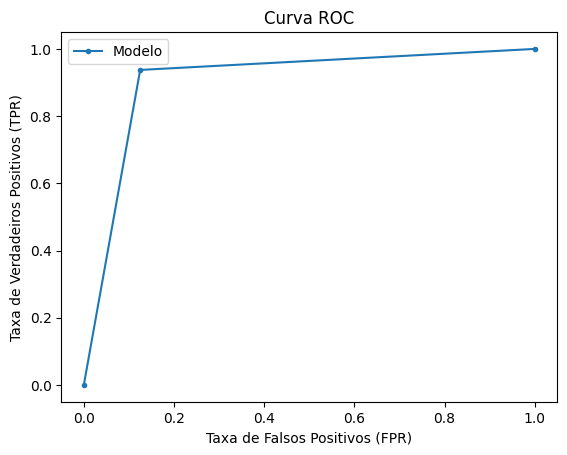

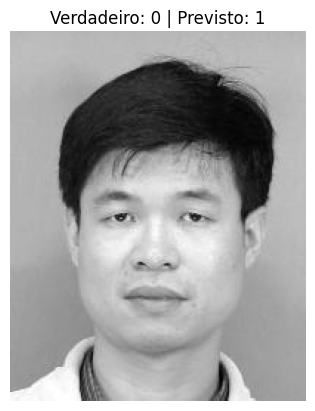

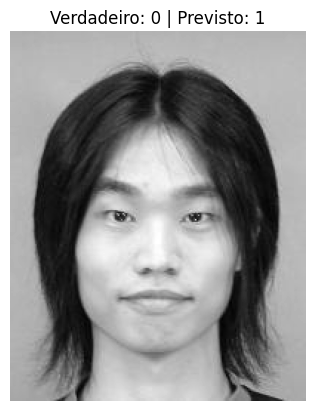

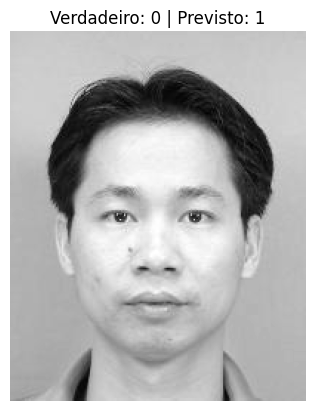

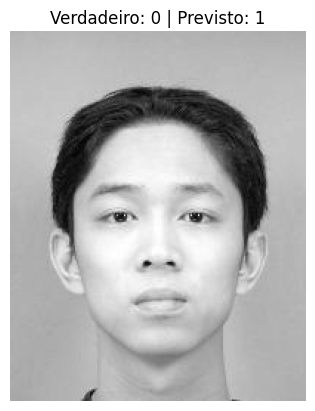

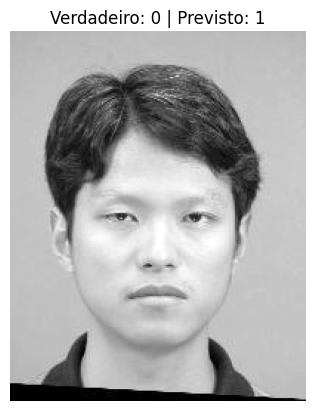

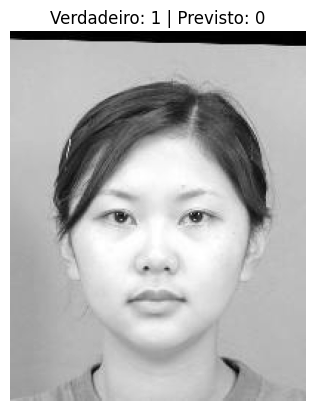

In [ ]:
auc = roc_auc_score(y_val, pred_labels)
print(f"AUC-ROC: {auc}")
f1 = f1_score(y_val, pred_labels)
print(f"F1-Score: {f1}")
fpr, tpr, thresholds = roc_curve(y_val, pred_labels)

# Plotando a curva ROC
plt.plot(fpr, tpr, marker='.', label='Modelo')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

for i in range(len(X_val)):
  if(y_val[i] != pred_labels[i][0]):#Analisando as fotos em que o modelo errou a
                                   #previsão
      plt.imshow(X_val[i].reshape(250, 200,1), cmap="gray")  # Ajuste as dimensões se necessário
      plt.title(f"Verdadeiro: {y_val[i]} | Previsto: {pred_labels[i][0]}")
      plt.axis('off')
      plt.show()

## Modelo com data augmentation

In [ ]:
labels = label_sex(photos_folder)

In [ ]:
normalized_images = norm_image(photos_folder)

In [ ]:
X = normalized_images  #Array de imagens normalizadas.
y = labels  #Rótulos.
#Eu estava um erro com o tamanho da entrada para o modelo. Aparentemente as
#dimensões estavam erradas no tensor. Essa função abaixo foi para ajeitar isso.

#Dividindo em treino + temporário (50% treino, 50% temporário).
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=23)
#Dividindo o conjunto temporário em validação + teste (60% validação, 40% teste).
#No final ficamos com 50% treino, 20% teste e 30% validação.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=23)






X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
train_generator = datagen.flow(
    X_train, y_train, batch_size=16
)

In [ ]:
tuner = kt.Hyperband(#Treinando o modelo com gridsearch
    best_hp,
    objective=kt.Objective("accuracy", direction="max"),  # Maximizar o F1-score
    max_epochs=20,
    factor=3,
    directory='model_results_3',
    project_name='grid_search_data_ag'
)

Reloading Tuner from model_results_3/grid_search_data_ag/tuner0.json


In [ ]:
#Pode demorar cerca de 13 min
tuner.search(train_generator, epochs=20, validation_data=(X_test, y_test))

Trial 26 Complete [00h 00m 55s]
accuracy: 0.7127659320831299

Best accuracy So Far: 0.8297872543334961
Total elapsed time: 00h 18m 24s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Melhores hiperparâmetros encontrados: {best_hps.values}")

Melhores hiperparâmetros encontrados: {'filters': 31, 'learning_rate': 0.001, 'activation': 'relu', 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:
activation = 'relu'
filters = 31
lr = 0.001
model = top_melhores_cnn_da_residencia(3,'DA-1882',activation,filters,lr)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "DA-1882"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 250, 200, 62)        │           6,758 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 125, 100, 62)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 100, 124)       │         192,324 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 50, 124)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 62, 50, 186)         │         369,210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 25, 186)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 31, 25, 248)         │         415,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 12, 248)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 44640)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          44,641 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,028,333 (3.92 MB)

 Trainable params: 1,028,333 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='loss',   # Métrica a ser monitorada
    patience=9,           # Número de épocas sem melhoria antes de parar
    restore_best_weights=True  # Restaura os pesos da melhor época
)

In [ ]:

 history = model.fit(train_generator,#usar searchgrig hyperopt
          batch_size=16,
          epochs=50,
          verbose=1,
          callbacks=[early_stopping])


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7986 - loss: 0.4639
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8161 - loss: 0.3881
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8379 - loss: 0.4283
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8341 - loss: 0.3999
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8441 - loss: 0.3495
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7683 - loss: 0.4608
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7824 - loss: 0.3992
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8112 - loss: 0.4169
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7715 - loss: 0.5031
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8835 - loss: 0.3286
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8341 - loss: 0.3362
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8288 - loss: 0.3951
E

In [ ]:
model.save('face_model.keras')

In [ ]:
val_loss, val_accuracy= model.evaluate(X_val, y_val, verbose=1)
print(f"Loss na validação: {val_loss}")
print(f"Acurácia na validação: {val_accuracy_data_ag}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8869 - loss: 0.2501
Loss na validação: 0.24443957209587097
Acurácia na validação: 0.8928571343421936


In [ ]:
pred = model.predict(X_val)
pred_labels = (pred > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


AUC-ROC: 0.8312499999999999
F1-Score: 0.7857142857142857


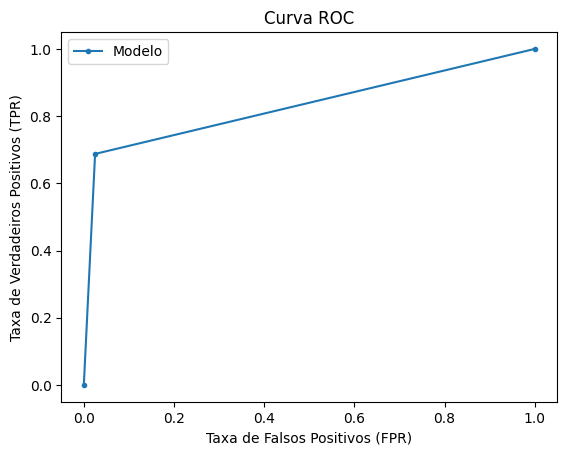

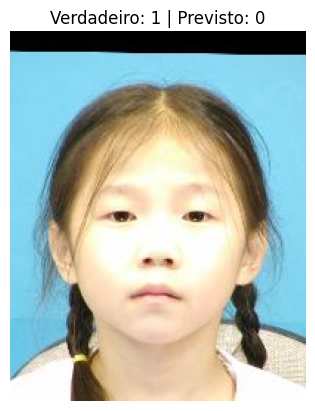

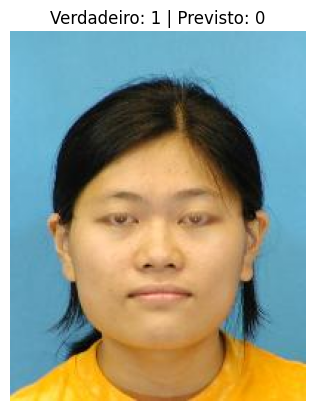

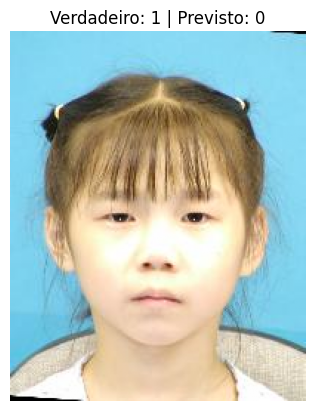

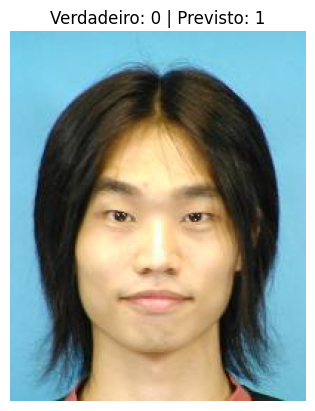

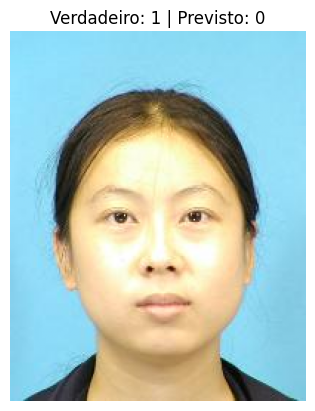

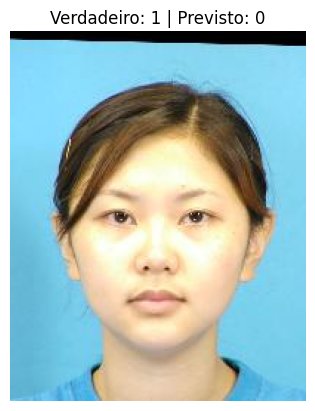

In [ ]:
auc = roc_auc_score(y_val, pred_labels)
print(f"AUC-ROC: {auc}")
f1 = f1_score(y_val, pred_labels)
print(f"F1-Score: {f1}")
fpr, tpr, thresholds = roc_curve(y_val, pred_labels)

# Plotando a curva ROC
plt.plot(fpr, tpr, marker='.', label='Modelo')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

for i in range(len(X_val)):
  if(y_val[i] !=pred_labels[i][0]):#Analisando as fotos em que o modelo errou a
                                   #previsão
      plt.imshow(X_val[i].reshape(250, 200,3), cmap=None)
      plt.title(f"Verdadeiro: {y_val[i]} | Previsto: {pred_labels[i][0]}")
      plt.axis('off')
      plt.show()